<a href="https://colab.research.google.com/github/Dyani99/MSBD-566---Final-Project-/blob/main/Autism_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dimensionality Reduction - PCA Method

In [ ]:
# Import modules
import numpy as np
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot

# import PCA module
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
# Import and load data
data, meta = arff.loadarff("/content/Autism-Adult-Data.arff")
df_raw = pd.DataFrame(data)
print(f"Rows: {df_raw.shape[0]}, Columns: {df_raw.shape[1]}")
print(df_raw.head(3), "\n")

Rows: 704, Columns: 21
  A1_Score A2_Score A3_Score A4_Score A5_Score A6_Score A7_Score A8_Score  \
0     b'1'     b'1'     b'1'     b'1'     b'0'     b'0'     b'1'     b'1'   
1     b'1'     b'1'     b'0'     b'1'     b'0'     b'0'     b'0'     b'1'   
2     b'1'     b'1'     b'0'     b'1'     b'1'     b'0'     b'1'     b'1'   

  A9_Score A10_Score  ...  gender          ethnicity jundice  austim  \
0     b'0'      b'0'  ...    b'f'  b'White-European'   b'no'   b'no'   
1     b'0'      b'1'  ...    b'm'          b'Latino'   b'no'  b'yes'   
2     b'1'      b'1'  ...    b'm'          b'Latino'  b'yes'  b'yes'   

      contry_of_res used_app_before result        age_desc   relation  \
0  b'United States'           b'no'    6.0  b'18 and more'    b'Self'   
1         b'Brazil'           b'no'    5.0  b'18 and more'    b'Self'   
2          b'Spain'           b'no'    8.0  b'18 and more'  b'Parent'   

  Class/ASD  
0     b'NO'  
1     b'NO'  
2    b'YES'  

[3 rows x 21 columns] 



In [ ]:
# Import modules needed for this cell (if not already imported)
from numpy._core import numeric
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# RE-LOAD DATA: Ensure df_raw is correctly populated
# This addresses the issue where df_raw appeared to be all NaNs from the kernel state
# but the previous cell's print output indicated otherwise.
data, meta = arff.loadarff("/content/Autism-Adult-Data.arff")
df_raw = pd.DataFrame(data)

# Decode byte strings to regular strings in df_raw for all object columns
object_cols = df_raw.select_dtypes(include='object').columns
for col in object_cols:
    # Use .str.decode() which is more robust for Series containing bytes and NaNs
    df_raw[col] = df_raw[col].str.decode('utf-8')

x = df_raw.drop(columns=['Class/ASD'])
y = df_raw['Class/ASD']

# Convert A_Score columns from string '1'/'0' to int 1/0
for col in [f"A{i}_Score" for i in range(1,11)]:
    # Fill any potential NaN values with '0' (as a string) before converting to int
    x[col] = x[col].fillna('0').astype(int)

# Convert 'yes'/'no' columns to 1/0, NaNs will be handled by imputer
for col in ['austim', 'jundice', 'used_app_before']:
    x[col] = x[col].map({'yes': 1, 'no': 0})

numeric_features = ['result']
binary_features = [f"A{i}_Score" for i in range(1,11)] + [
    'austim', 'jundice', 'used_app_before'
]
categorical_features =['gender', 'ethnicity', 'contry_of_res', 'age_desc', 'relation']

# Preprocessing for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing for binary features
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')) # Impute NaNs with most frequent (0 or 1)
])

# Preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('bin', binary_transformer, binary_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Apply preprocessing and the output should now be dense and without NaNs
X_preprocessed = preprocessor.fit_transform(x)

In [ ]:
pca = PCA(n_components=0.95, svd_solver='full')
X_pca = pca.fit_transform(X_preprocessed)

print(f"Original number of features: {X_preprocessed.shape[1]}")
print(f"Reduced number of features: ", X_pca.shape[1])
print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_)}")

Original number of features: 102
Reduced number of features:  30
Explained variance ratio: 0.9524383495197819


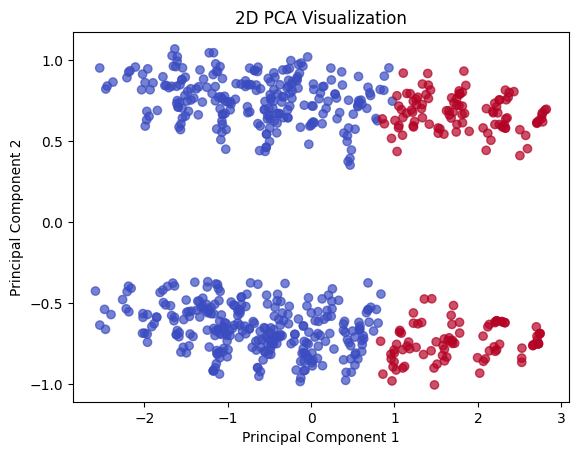

In [ ]:
import matplotlib.pyplot as plt

# Create a 2D PCA visualization
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_preprocessed)

# Convert y labels to numerical values for coloring
y_numeric = y.map({'NO': 0, 'YES': 1})

plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_numeric, cmap='coolwarm', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA Visualization')
plt.show()

Neural Network

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

mlp = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    activation='relu',
    solver='adam',
    alpha=0.001,
    max_iter=400,
    random_state=42
)

mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
y_prob = mlp.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9432624113475178
ROC AUC: 0.9925907000510986

Classification Report:
               precision    recall  f1-score   support

          NO       0.94      0.98      0.96       103
         YES       0.94      0.84      0.89        38

    accuracy                           0.94       141
   macro avg       0.94      0.91      0.93       141
weighted avg       0.94      0.94      0.94       141



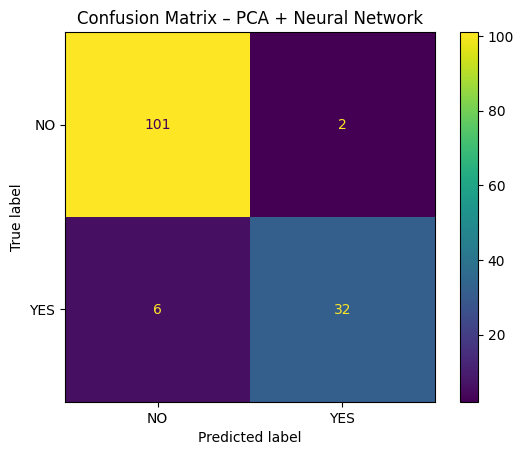

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix – PCA + Neural Network")
plt.show()

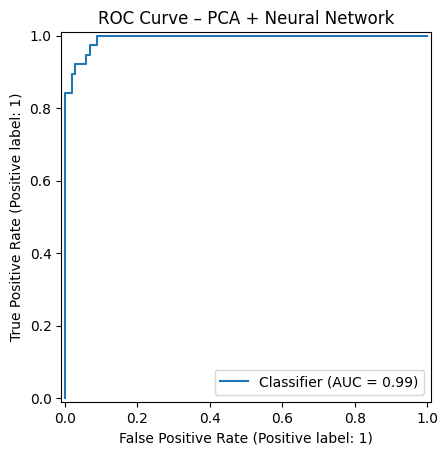

In [ ]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# Convert y_test labels to numerical values for RocCurveDisplay
y_test_numeric = y_test.map({'NO': 0, 'YES': 1})

RocCurveDisplay.from_predictions(y_test_numeric, y_prob)
plt.title("ROC Curve – PCA + Neural Network")
plt.show()